In [25]:
import requests
import json
import git
import string
import os
import sys
import yaml
from collections import defaultdict, namedtuple, OrderedDict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
sys.path.append('../repo')
from dbaccessor import DBAccessor
from pythonlinting import lint_file_or_project
from util import format_filename

# Language Influences on Code Style

Who is the better python programmer? Java developers or C++ developers?

To answer this and other questions, over the course of the seminar "Code Repository Mining" in the Winter Term 2017/18 I have developed a few scripts and a small application in the hope to show some effects of programming experience when switching to another language.
This notebook and the corresponding [repository](https://github.com/shorschig/Language_Influences_On_Codestyle) is a concise representation and documentation of my work so far.

## Motivation

What can we do with such information.
Well, first, let's focus on _what_ errors are actually made by _which_ type of programmer. For example, do Java developers have the tendency to wrap everything in classes when there is really no need for it should they get their hands on Python? Do Python developers cause memory leaks in C++ due to soem structures they often use falsely?
If we can find such "Design Defects" and their correlation to previous programming experience, we have the ability to work in a way to reduce this effects beforehand: Maybe we can create a "Python Tutorial for Java Developers" that precisely focuses to avoid error that are oftentimes produced by such developers.
Different communities also focus on different styles, for example in most python programs, it's all about conciseness. If we find such relations, can we see programming patterns relating o that and how can different communities influence a persons own coding style?

There are much, much more open questions to answer, but let's get to the methods.

## Methods

### General Setup

The most important prerequisite is a clone of the [GHTorrent](http://ghtorrent.org) database, storing all the commits for all the users made on GitHub. This is the data the whole script works on.

Secondly, in order for this notebook to run properly, you have to setup the aforementioned [repository](https://github.com/shorschig/Language_Influences_On_Codestyle). Note the installations instructions in the README.md, __especially the config part__.
Please adjust the import at the top according to the position of the repository in your file system.

Third, you have to create the table this script works with manually if you want to change the programming languages to explore further influences. Please have a look at the current [Create Statement](https://github.com/shorschig/Language_Influences_On_Codestyle/blob/master/languages_per_author.sql) if you wonder how this table was created.
_Note_: This is not included in the script due to the enormous runtime of the query, this may take up to a week depending on the languages you choose, as the `raw_patches` table is huge. 

Last but not least, this is an information for the context of the following notebook: __The programming influence that is researched here is the influence on Python code style, coming from a Java or a C++ background. Other programming language pairs can also be used based on this work, only the analyzing part of the repository (using the linter) and the table in the databse has to be adjusted.__ 

In [ ]:
config = {}
with open('../repo/config.yml', 'r') as cfg:
    config = yaml.load(cfg)
print(config)

In [9]:
LANGUAGES = ['cpp', 'java', 'python']
TARGET_LANGUAGE = 'python'
BG_LANGS = [l for l in LANGUAGES if l != TARGET_LANGUAGE]

#### Terms Used

Just a short clarification: There are two types of programming language when I talk about this project. 
The first is the __target language__ or __secondary language__, in this case Python. This is the language we do our analysis with, analyze design defects and plot diagrams for. This is the language most of our candidates are _not_ the _most_ proficient with.
The second is the __background language__ or __main language__, defining the background of the programmer. This is the langauge our candidates are the most proficient with and defines their background.

### Data

The data I worked on was provided by the [GHTorrent](http://ghtorrent.org) database. The tables mainly used were the `commits`, `raw_patches` and `projects` tables. For further information, look into the [Create Statement](https://github.com/shorschig/Language_Influences_On_Codestyle/blob/master/languages_per_author.sql) or the [database module](https://github.com/shorschig/Language_Influences_On_Codestyle/blob/master/dbaccessor.py). The latter also explains how exactly candidates are selected. This is also shortly explained in the next paragraph.

### Candidates

In the following text and snippets, we will have a look at the candidates for our exploration of the topics. 
A preselection was already performed when the table we're working with was created: It summarizes all the changes for all authors for our wanted programming languages.
Now, we want to find programmers, who:
+ have significant programming experience in our target language and
+ have more experience in their background language than in theri target language and
+ have _only_ significant experience in those two langauges, so we can eliminate effects from other backgrounds.

(The last point constitutes an optimal case, but I try to limit my results based on this point, too.)

This poses two questions for different thresholds: 
How much experience is _significant_?
How much _more_ do they have to have programmed?

#### Significance Threshold

At this point, I decided to answer the first question by plotting the number of candidates at various thresholds. This threshold at this point describes LOC, or more precisely changes done in Git.

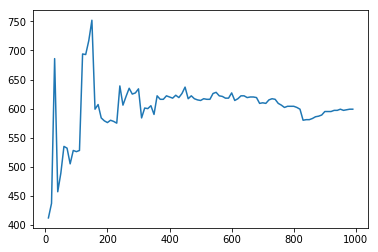

Peak at  150


In [10]:
# Find optimal threshold of lines to have programmed at least
db = DBAccessor(config)
num_cands = []
threshs = []
for thresh in range(10, 1000, 10):
    bg_cands = 0
    for bg_lang in BG_LANGS:
        bg_cands += len(db.get_candidates(bg_lang, TARGET_LANGUAGE, thresh, 1))
    num_cands.append(bg_cands)
    threshs.append(thresh)
plt.plot(threshs, num_cands)
plt.show()
print('Peak at ', threshs[num_cands.index(max(num_cands))])

As we can see a peak at 150 changes, i chose this threshold for further experiments. Not that this curve is not monotonous as with a higher threshold, more candidates come in the set due to the fact that they are allowed to have more experience in the third language while still not being counted as a programmer of that language.

#### Multiplier Threshold

To answer the second question, I also plotted the corresponding number of candidates for different experience multipliers. The sinificance threshold used here are the 150 as seen before. 

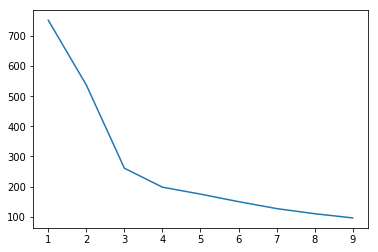

In [11]:
num_cands = []
threshs = []
for thresh in range(1, 10):
    bg_cands = 0
    for bg_lang in BG_LANGS:
        bg_cands += len(db.get_candidates(bg_lang, TARGET_LANGUAGE, 150, thresh))
    num_cands.append(bg_cands)
    threshs.append(thresh)
plt.plot(threshs, num_cands)
plt.show()

Due to this fact that this curve is monotonously falling and there really is no unexpected peak, I just chose a threshold of 5 for the further process. This more or less ensures a significant difference in experience while still having a lot of candidates for the process.

___

After the thresholds for the candidate selection are chosen, we can take a look at the projects we want to analyze.

### Project Selection

#### Fetching Candidates

The first step is simply to fetch all the candidates with the given thresholds from the table, including a baseline of programmers with the same background as our target language.

In [20]:
# Get author_ids for every candidate
candidates = {}
for bg_lang in BG_LANGS:
    candidates[bg_lang] = [c[0] for c in db.get_candidates(bg_lang, TARGET_LANGUAGE)]
candidates[TARGET_LANGUAGE] = [c[0] for c in db.get_baseline_programmers(TARGET_LANGUAGE)]
for bg_lang, cands in candidates.items():
    print('{} {} candidates found.'.format(len(cands), bg_lang))

84 java candidates found.
100 python candidates found.
91 cpp candidates found.


#### Fetching projects

Next, we want to find the projects for each user.

In [21]:
projects = defaultdict(set)

for lang in LANGUAGES:
    for candidate in candidates[lang]:
        projects[lang].update(db.get_projects_for_user(candidate, TARGET_LANGUAGE))
    print('{} projects for {} candidates found.'
          .format(len(projects[lang]), lang))

41 projects for cpp candidates found.
45 projects for java candidates found.
424 projects for python candidates found.


Some projects are not reachable. Maybe the URL is not the most recent, it was moved, set to private or other things. So let's filter them out and stick with the projects we can actually access.

_Note_: Due to the amount of requests we have to send here, we need a GitHub API token. This should be in your config file. If you wonder how you can get one, look [here](https://github.com/settings/tokens). 

In [22]:
token = config['github-token']
ghuser = config['github-user']
Project = namedtuple('Project', ['url', 'name'])
existing_projects = defaultdict(list)
for lang in LANGUAGES:
    for project in projects[lang]:
        r = requests.get(project[0], auth=(ghuser, token))
        obj = json.loads(r.text)
        if 'clone_url' in obj.keys():
            existing_projects[lang].append(Project(obj['clone_url'], project[1]))
    print('{} projects for {} are reachable.'
          .format(len(existing_projects[lang]), lang))

33 projects for cpp are reachable.
40 projects for java are reachable.
387 projects for python are reachable.


__Optional:__
#### Checking Out Projects

Unless the projects are already present in the filesystem, we can check them out with git. The path and credentials like GitHub token are again taken from the config.

In [23]:
print('Cloning repositories...')
for lang in LANGUAGES:
    for clone_url, name in existing_projects[lang]:
        try:
            git.Repo.clone_from(clone_url, config['repo-dir'] + lang + '/' +
                                format_filename(name))
        except:
            print('Clone failed, maybe directory already exists.')
print('Finished cloning.')

Cloning repositories...
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone fail

Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory alre

Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory already exists.
Clone failed, maybe directory alre

### Getting The Results

After we successfully saved all of the projects, we can start linting them.

_Attention: This step consumes a huge amount of time, be prepared before you start the next cell!_

In [26]:
error_occurences = {}
for lang in LANGUAGES:
    error_occurences[lang] = defaultdict(list)
    print('Linting projects for {}:'.format(lang))
    projects_folder = config['repo-dir'] + lang + '/'
    for project_dir in os.listdir(projects_folder):
        project_path = os.path.join(projects_folder, project_dir)
        print('Linting {}'.format(project_path))
        error_codes, num_files, num_lines = lint_file_or_project(project_path)
        for key, val in error_codes.most_common():
            error_occurences[lang][key].append((val, num_lines, project_path))
print(error_occurences)

Linting projects for cpp:
Linting /mnt/brick/crm-repos/shorschig/lics/cpp/sublime_terminal
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/sublime_terminal/Terminal.py
6.57
1 files parsed.
Linting /mnt/brick/crm-repos/shorschig/lics/cpp/fb_prune
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/fb_prune/fb_prune_tests.py
Lint failed, trying to lint as python2 file
15.0
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/fb_prune/fb_prune.py
Lint failed, trying to lint as python2 file
7.41
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/fb_prune/mock_graph_api.py
5.28
3 files parsed.
Linting /mnt/brick/crm-repos/shorschig/lics/cpp/HMMER-DB
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/HMMER-DB/TestHMMs.py
16.47
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/HMMER-DB/GenbankToFASTAandOrganismTableRow.py
13.68
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/HMMER-DB/lib.py
12.55
Processing /mnt/brick/crm-repos/shorschig/lics/cpp/HMMER-DB/hmm_parser.py
15.0
Processing /mn

Lint failed, trying to lint as python2 file
11.43
Processing /mnt/brick/crm-repos/shorschig/lics/java/seal-galaxy/seal/merge_alignments.py
Lint failed, trying to lint as python2 file
12.16
5 files parsed.
Linting /mnt/brick/crm-repos/shorschig/lics/java/SoundBox
Processing /mnt/brick/crm-repos/shorschig/lics/java/SoundBox/soundboxd.py
35.0
1 files parsed.
Linting /mnt/brick/crm-repos/shorschig/lics/java/C3
0 files parsed.
Linting /mnt/brick/crm-repos/shorschig/lics/java/persistent_dict
Processing /mnt/brick/crm-repos/shorschig/lics/java/persistent_dict/tests.py
Lint failed, trying to lint as python2 file
4.12
Processing /mnt/brick/crm-repos/shorschig/lics/java/persistent_dict/benchmark.py
Lint failed, trying to lint as python2 file
4.73
Processing /mnt/brick/crm-repos/shorschig/lics/java/persistent_dict/clone_dict.py
1.8399999999999999
Processing /mnt/brick/crm-repos/shorschig/lics/java/persistent_dict/persistent_dict.py
1.4600000000000009
4 files parsed.
Linting /mnt/brick/crm-repos/s

2.7
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/sensorintegratortest.py
8.91
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/memorytest.py
4.25
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/brain.py
Lint failed, trying to lint as python2 file
4.03
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/bbie/pstat.py
Lint failed, trying to lint as python2 file
13.28
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/bbie/intervalestimationtest.py
16.84
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/bbie/bbie.py
Lint failed, trying to lint as python2 file
9.39
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/bbie/intervalestimation.py
32.2
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/bbie/make_readable.py
Lint failed, trying to lint as python2 file
3.33
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/bbie/bbietest.py
8.97
Processing /mnt/brick/crm-

7.5
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/util/takeimages.py
Lint failed, trying to lint as python2 file
6.67
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/util/averageimages.py
Lint failed, trying to lint as python2 file
7.95
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/util/naovideo.py
Lint failed, trying to lint as python2 file
10.49
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/util/kinectvideo.py
Lint failed, trying to lint as python2 file
8.04
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/util/__init__.py
Lint failed, trying to lint as python2 file
Lint failed with python 2 and 3, skipping file.
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/util/takesnapshotskeyboard.py
Lint failed, trying to lint as python2 file
5.62
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/util/speed_angle.py
11.97
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjem

Lint failed, trying to lint as python2 file
6.9399999999999995
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/vision/obstacledetectorutil/calibrator.py
Lint failed, trying to lint as python2 file
5.86
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/vision/obstacledetectorutil/__init__.py
Lint failed, trying to lint as python2 file
Lint failed with python 2 and 3, skipping file.
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/vision/obstacledetectorutil/segmentizer.py
8.7
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/navigation/obstacleavoidance/vectorfieldtest.py
7.73
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/navigation/obstacleavoidance/obstacleavoider.py
Lint failed, trying to lint as python2 file
6.55
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/navigation/obstacleavoidance/vectorfield.py
Lint failed, trying to lint as python2 file
8.09
Processing /mnt/brick/crm-repos/shorschi

Lint failed with python 2 and 3, skipping file.
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/behavior/exampleblobdetector/exampleblobdetector_x.py
3.33
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/behavior/exampleblobdetector/exampleblobdetector_1.py
Lint failed, trying to lint as python2 file
5.42
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/behavior/exampleblobdetector/exampleblobdetector.py
28.4
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/behavior/exampleblobdetector/__init__.py
Lint failed, trying to lint as python2 file
Lint failed with python 2 and 3, skipping file.
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/behavior/soccer/soccer_1.py
Lint failed, trying to lint as python2 file
8.33
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/behavior/soccer/soccer.py
28.4
Processing /mnt/brick/crm-repos/shorschig/lics/python/Asjemenao/behavior/soccer/__init__.py
Lint failed, try

Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/setup.py
7.27
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/csrf.py
1.6300000000000008
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/paster.py
1.8800000000000008
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/threadlocal.py
3.5
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tweens.py
2.38
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/wsgi.py
2.7800000000000002
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/events.py
5.25
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/resource.py
22.5
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/viewderivers.py
1.7599999999999998
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/renderers.py
1.8800000000000008
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/registry

3.67
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/adapters.py
4.83
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/rendering.py
3.33
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/routes.py
2.3499999999999996
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/tweens.py
2.9699999999999998
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/views.py
3.6100000000000003
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/factories.py
2.62
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/util.py
2.33
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/assets.py
1.75
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/predicates.py
30.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/config/settings.py
1.5399999999999991
Processi

15.559999999999999
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/restbugapp/views.py
10.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/restbugapp/__init__.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/notfoundview/__init__.py
7.779999999999999
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/subrequestapp/__init__.py
2.5599999999999996
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/viewdecoratorapp/__init__.py
15.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/hybridapp/views.py
12.629999999999999
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/hybridapp/__init__.py
10.95
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/pyramid/tests/pkgs/static_assetspec/__init__.py
15.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyram

7.140000000000001
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tour/logging/hello_world/__init__.py
8.75
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tour/sqla_demo/sqla_demo/routes.py
6.67
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tour/sqla_demo/sqla_demo/tests.py
4.62
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tour/sqla_demo/sqla_demo/__init__.py
8.75
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tour/sqla_demo/sqla_demo/scripts/initializedb.py
7.3100000000000005
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tour/sqla_demo/sqla_demo/scripts/__init__.py
Lint failed, trying to lint as python2 file
Lint failed with python 2 and 3, skipping file.
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tour/sqla_demo/sqla_demo/models/meta.py
26.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyra

11.25
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/static_assets/tutorial/views.py
13.75
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/static_assets/tutorial/tests.py
5.29
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/static_assets/tutorial/__init__.py
10.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/jinja2/tutorial/views.py
13.75
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/jinja2/tutorial/tests.py
5.48
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/jinja2/tutorial/__init__.py
11.25
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/routing/tutorial/views.py
11.25
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/quick_tutorial/routing/tutorial/tests.py
5.77
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/doc

10.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/tests/setup.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/authentication/setup.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/installation/setup.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/basiclayout/setup.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/models/setup.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/views/setup.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/authorization/setup.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/tests/tutorial/routes.py
5.76
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/tests/tutorial/sec

9.58
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/basiclayout/tutorial/views/default.py
15.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/basiclayout/tutorial/views/__init__.py
Lint failed, trying to lint as python2 file
Lint failed with python 2 and 3, skipping file.
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/basiclayout/tutorial/views/notfound.py
17.5
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/models/tutorial/routes.py
6.67
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/models/tutorial/tests.py
5.9
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/models/tutorial/__init__.py
8.75
Processing /mnt/brick/crm-repos/shorschig/lics/python/pyramid/docs/tutorials/wiki2/src/models/tutorial/scripts/initializedb.py
5.94
Processing /mnt/brick/crm-repo

5.56
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/test_runner.py
5.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/test_buffers.py
4.18
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/__init__.py
Lint failed, trying to lint as python2 file
Lint failed with python 2 and 3, skipping file.
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/test_regression.py
4.74
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/test_functional.py
23.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/test_channel.py
5.59
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/fixtureapps/writecb.py
1.67
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/fixtureapps/getline.py
4.0
Processing /mnt/brick/crm-repos/shorschig/lics/python/waitress/waitress/tests/fixtureapps/toolarge.py
8

#### Normalizing

Afterwards, to better plot the results, we can easily normalize them as we already have the number of occurrences and the number of the lines that were analyzed.

We're dragging the path to the project down here so that we can trace back any outliers at the end.

In [27]:
normalized_error_occurences = {}
for lang in LANGUAGES:
    normalized_error_occurences[lang] = {}
    for k, v in error_occurences[lang].items():
        normalized_error_occurences[lang][k] = [(u[0] / u[1], u[2]) for u in v]
print(normalized_error_occurences)

{'java': {('W0201', ' attribute-defined-outside-init'): [(0.0006605019815059445, '/mnt/brick/crm-repos/shorschig/lics/java/comp2013_14')], ('C0413', ' wrong-import-position'): [(0.0005697194131890044, '/mnt/brick/crm-repos/shorschig/lics/java/university')], ('R1705', ' no-else-return'): [(0.0022788776527560175, '/mnt/brick/crm-repos/shorschig/lics/java/university'), (0.001834862385321101, '/mnt/brick/crm-repos/shorschig/lics/java/persistent_dict'), (0.001321003963011889, '/mnt/brick/crm-repos/shorschig/lics/java/comp2013_14')], ('W0311', ' bad-indentation'): [(0.0031334567725395243, '/mnt/brick/crm-repos/shorschig/lics/java/university'), (0.3668763102725367, '/mnt/brick/crm-repos/shorschig/lics/java/seal-galaxy')], ('R0915', ' too-many-statements'): [(0.0001424298532972511, '/mnt/brick/crm-repos/shorschig/lics/java/university')], ('E0602', ' undefined-variable'): [(0.014670274889616863, '/mnt/brick/crm-repos/shorschig/lics/java/university'), (0.0020964360587002098, '/mnt/brick/crm-repo

__Optional:__

#### Grouping

Due to the fact that design defects falling in the category "convention" (error code "C") happen way more often than those falling in the "refactoring" category (error code "R"), it makes sense to group the occurrences by each available code. This makes looking at the plots much easier.

_Note: This is currently not used in the plots at the end of this notebook, because we only plot differences for each code. This is useful if you want to plot the results for one language only._ 

In [ ]:
normalized_error_codes = defaultdict(dict)
for lang in LANGUAGES:
    for k, v in normalized_error_occurences[lang].items():
        normalized_error_codes[lang][k[0][0]].update({k:v})
print(normalized_error_codes)

### Analyzing Significance

Now, most importantly, we want to make plots for specific error codes to find out: Is a specific design defect more often done by a programmer with a specific background as opposed to one who doesn't have that background?

In order to filter this selection a little bit, we want to apply a [significance test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) to test the distribution of two samples. (The first idea that comes to mind concerning significance test may be the [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), but as it only works on normal distributions and there are not enough samples sometimes to even check for a normal distribution, I chose a nonparametric test for this purpose.)

In [30]:
# stores the significance values of a background language compared to the target language
target_signif = {}
for bg_lang in BG_LANGS:
    target_signif[bg_lang] = {}
    for err_code in normalized_error_occurences[bg_lang].keys():
        if err_code in normalized_error_occurences[TARGET_LANGUAGE].keys():
            bg_data = normalized_error_occurences[bg_lang][k]
            target_data = normalized_error_occurences[TARGET_LANGUAGE][k]
            twosample_results = stats.mannwhitneyu(bg_data, target_data)
            target_signif[bg_lang][err_code] = twosample_results
    target_signif[bg_lang] = OrderedDict(sorted(target_signif[bg_lang].items(), key=lambda t: t[1][1]))
print(target_signif)

{'java': OrderedDict([(('W0201', ' attribute-defined-outside-init'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('C0413', ' wrong-import-position'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('R1705', ' no-else-return'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('W0311', ' bad-indentation'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('R0915', ' too-many-statements'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('E0602', ' undefined-variable'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('E0401', ' import-error'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('W0511', ' fixme'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('C0305', ' trailing-newlines'), MannwhitneyuResult(statistic=-5.0, pvalue=2.1513897318375606e-06)), (('E1101', ' no-member'), MannwhitneyuResult(statistic=-5.0, p

If the resulting _p-value_ is less than 0.05, we can assume significance and plot the results.

In [29]:
plot_signifs = defaultdict(dict)

for bg_lang in BG_LANGS: 
    for err_code, test_result in target_signif[bg_lang].items():
        if test_result[1] < 0.05:
            plot_signifs[err_code][bg_lang] = round(test_result[1], 4)
print(plot_signifs)

defaultdict(<class 'dict'>, {('W0201', ' attribute-defined-outside-init'): {'java': 0.0}, ('C0413', ' wrong-import-position'): {'java': 0.0, 'cpp': 0.0}, ('R1705', ' no-else-return'): {'java': 0.0, 'cpp': 0.0}, ('W0311', ' bad-indentation'): {'java': 0.0, 'cpp': 0.0}, ('R0915', ' too-many-statements'): {'java': 0.0, 'cpp': 0.0}, ('E0602', ' undefined-variable'): {'java': 0.0, 'cpp': 0.0}, ('W0703', ' broad-except'): {'cpp': 0.0}, ('E0401', ' import-error'): {'java': 0.0, 'cpp': 0.0}, ('W0511', ' fixme'): {'java': 0.0, 'cpp': 0.0}, ('W0401', ' wildcard-import'): {'cpp': 0.0}, ('C0305', ' trailing-newlines'): {'java': 0.0, 'cpp': 0.0}, ('E1101', ' no-member'): {'java': 0.0, 'cpp': 0.0}, ('W0123', ' eval-used'): {'java': 0.0}, ('W0621', ' redefined-outer-name'): {'java': 0.0, 'cpp': 0.0}, ('C0301', ' line-too-long'): {'java': 0.0, 'cpp': 0.0}, ('W0312', ' mixed-indentation'): {'java': 0.0, 'cpp': 0.0}, ('W0622', ' redefined-builtin'): {'java': 0.0, 'cpp': 0.0}, ('W0106', ' expression-not-

### Plotting

After we finally got all the data and analyzed for significance, we can take a look at the results.

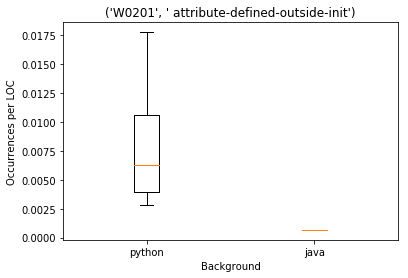

p-values:  {'java': 0.0}


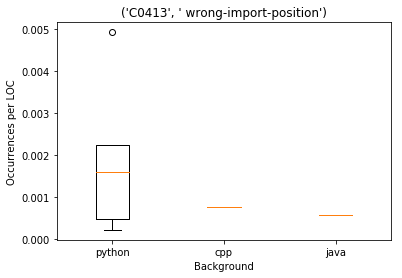

p-values:  {'java': 0.0, 'cpp': 0.0}


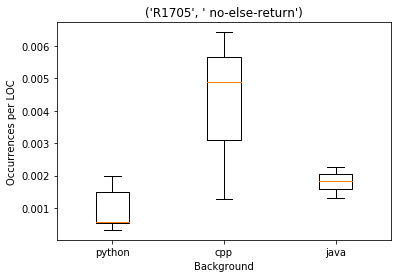

p-values:  {'java': 0.0, 'cpp': 0.0}


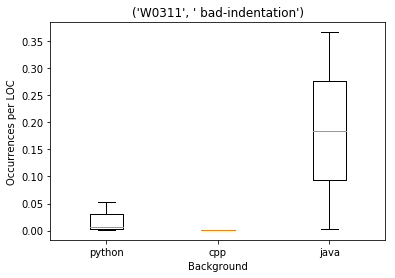

p-values:  {'java': 0.0, 'cpp': 0.0}


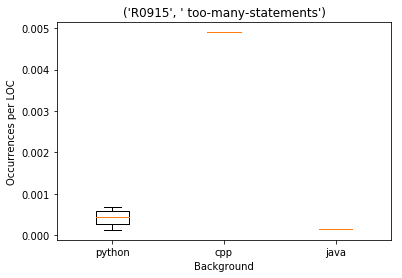

p-values:  {'java': 0.0, 'cpp': 0.0}


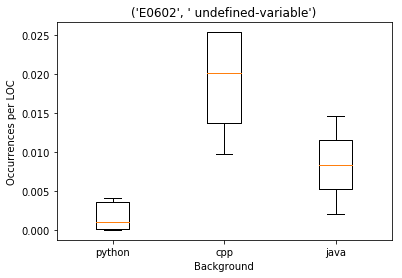

p-values:  {'java': 0.0, 'cpp': 0.0}


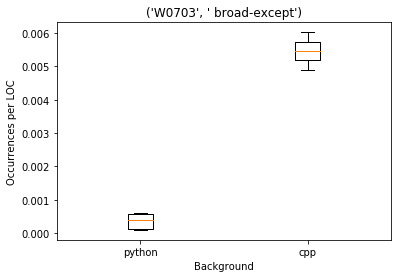

p-values:  {'cpp': 0.0}


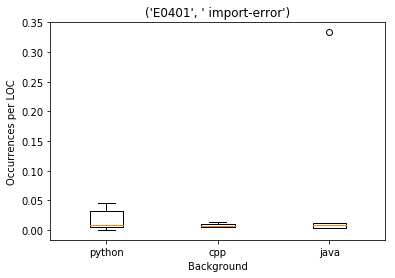

p-values:  {'java': 0.0, 'cpp': 0.0}


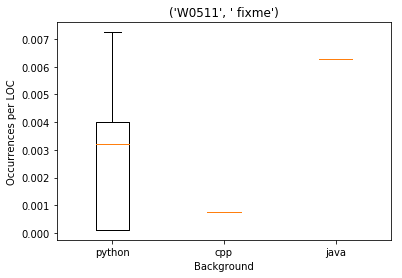

p-values:  {'java': 0.0, 'cpp': 0.0}


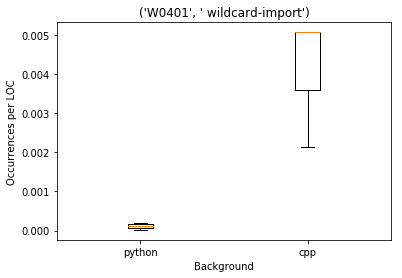

p-values:  {'cpp': 0.0}


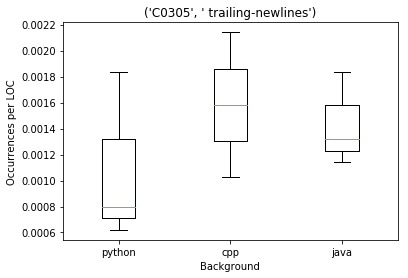

p-values:  {'java': 0.0, 'cpp': 0.0}


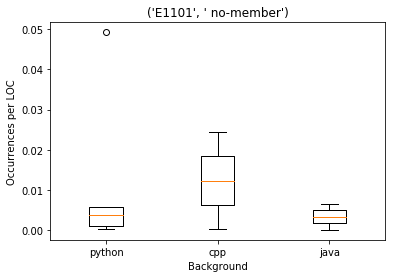

p-values:  {'java': 0.0, 'cpp': 0.0}


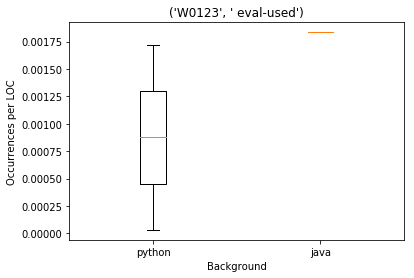

p-values:  {'java': 0.0}


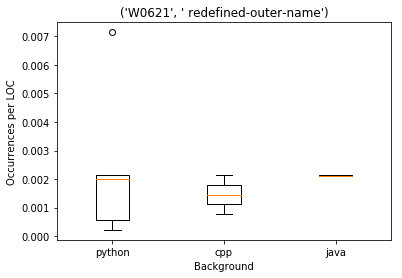

p-values:  {'java': 0.0, 'cpp': 0.0}


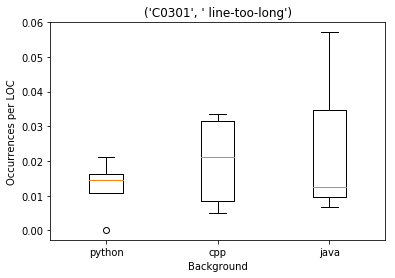

p-values:  {'java': 0.0, 'cpp': 0.0}


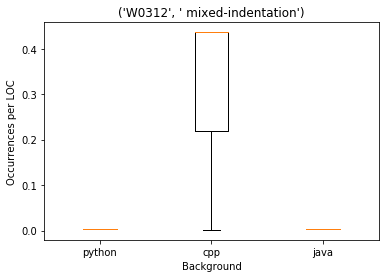

p-values:  {'java': 0.0, 'cpp': 0.0}


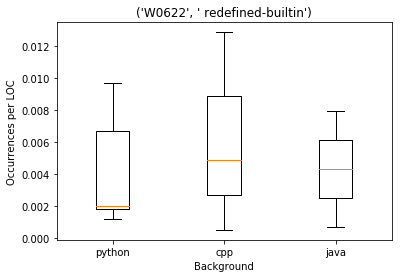

p-values:  {'java': 0.0, 'cpp': 0.0}


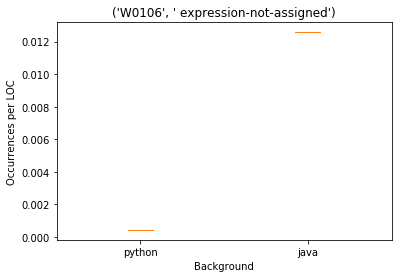

p-values:  {'java': 0.0}


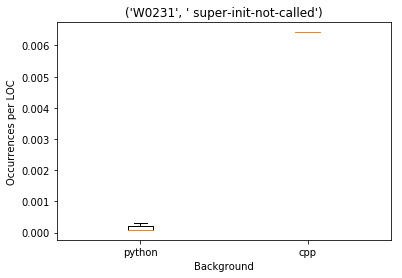

p-values:  {'cpp': 0.0}


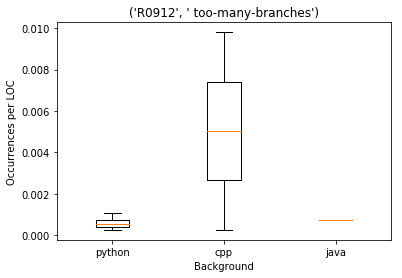

p-values:  {'java': 0.0, 'cpp': 0.0}


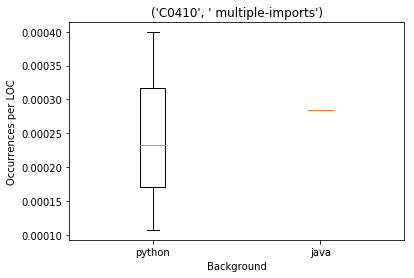

p-values:  {'java': 0.0}


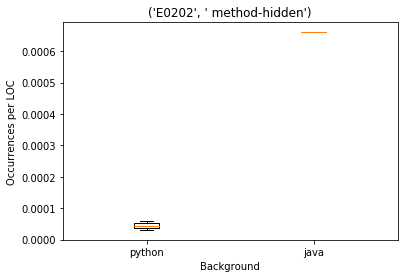

p-values:  {'java': 0.0}


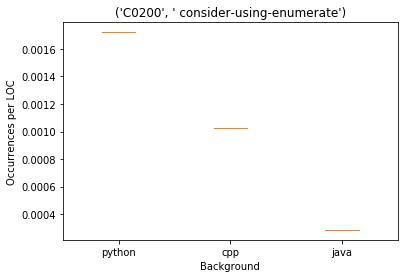

p-values:  {'java': 0.0, 'cpp': 0.0}


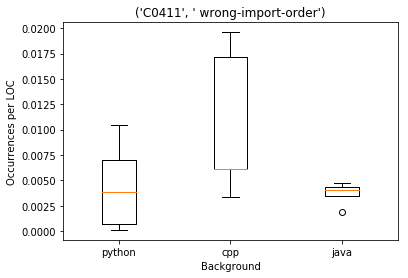

p-values:  {'java': 0.0, 'cpp': 0.0}


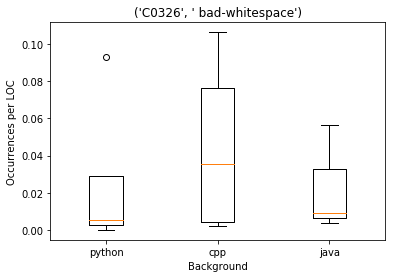

p-values:  {'java': 0.0, 'cpp': 0.0}


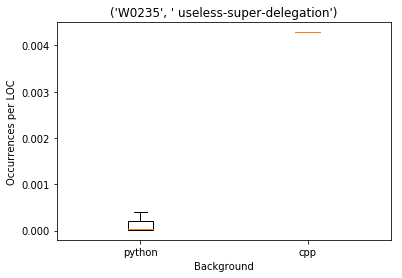

p-values:  {'cpp': 0.0}


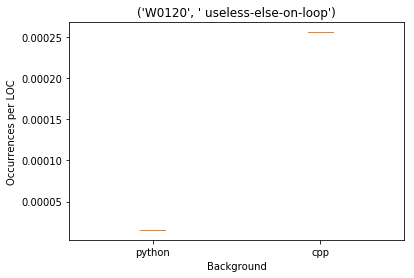

p-values:  {'cpp': 0.0}


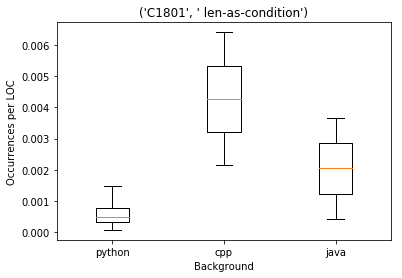

p-values:  {'java': 0.0, 'cpp': 0.0}


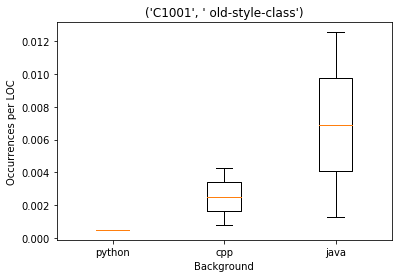

p-values:  {'java': 0.0, 'cpp': 0.0}


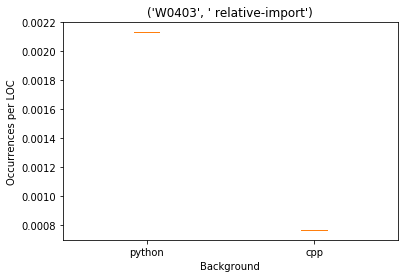

p-values:  {'cpp': 0.0}


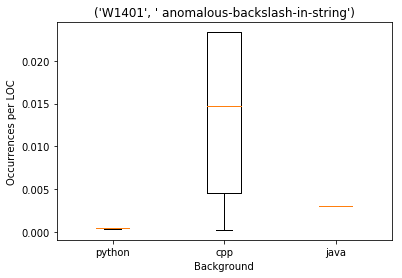

p-values:  {'java': 0.0, 'cpp': 0.0}


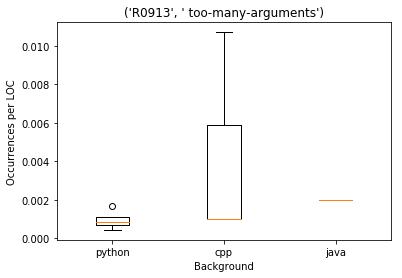

p-values:  {'java': 0.0, 'cpp': 0.0}


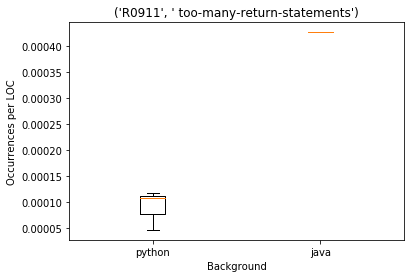

p-values:  {'java': 0.0}


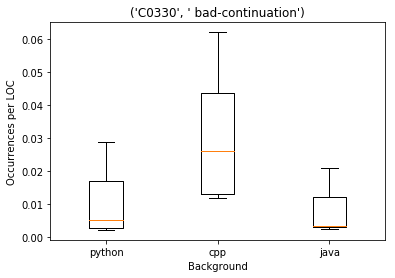

p-values:  {'java': 0.0, 'cpp': 0.0}


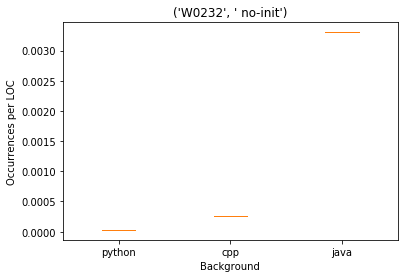

p-values:  {'java': 0.0, 'cpp': 0.0}


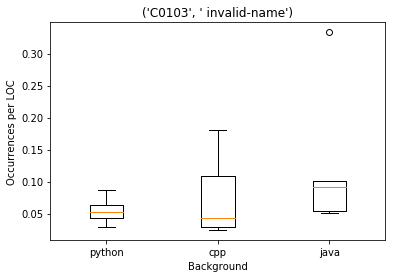

p-values:  {'java': 0.0, 'cpp': 0.0}


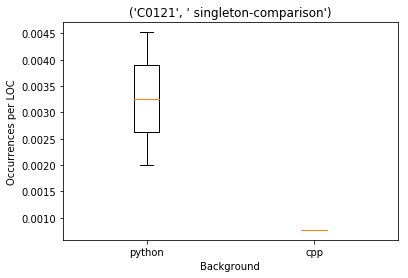

p-values:  {'cpp': 0.0}


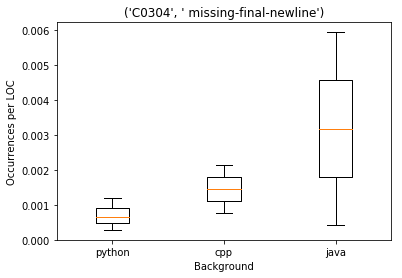

p-values:  {'java': 0.0, 'cpp': 0.0}


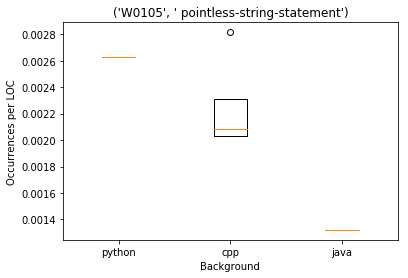

p-values:  {'java': 0.0, 'cpp': 0.0}


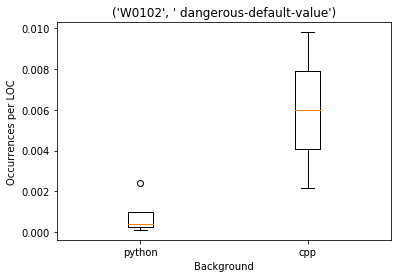

p-values:  {'cpp': 0.0}


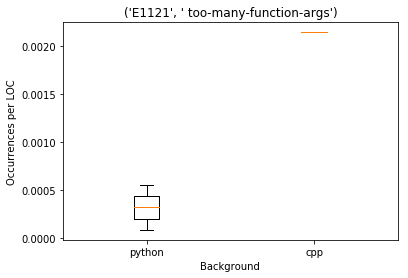

p-values:  {'cpp': 0.0}


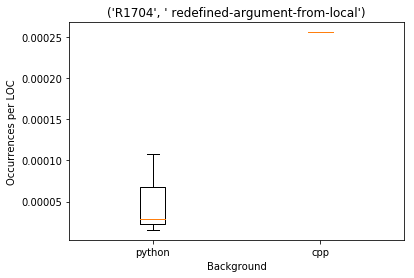

p-values:  {'cpp': 0.0}


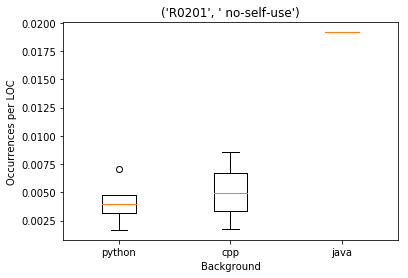

p-values:  {'java': 0.0, 'cpp': 0.0}


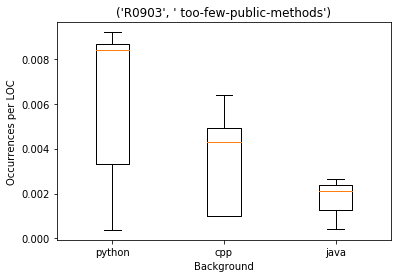

p-values:  {'java': 0.0, 'cpp': 0.0}


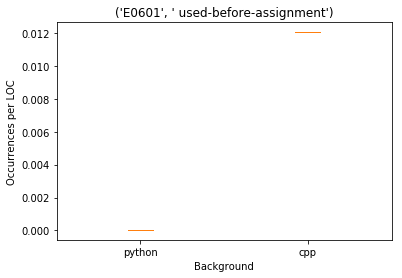

p-values:  {'cpp': 0.0}


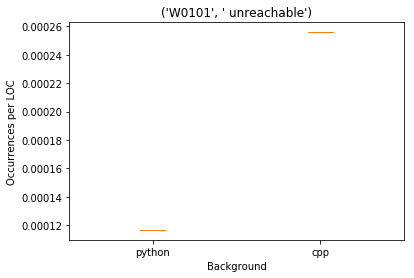

p-values:  {'cpp': 0.0}


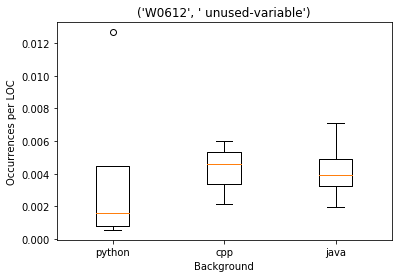

p-values:  {'java': 0.0, 'cpp': 0.0}


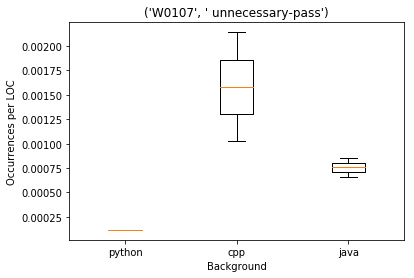

p-values:  {'java': 0.0, 'cpp': 0.0}


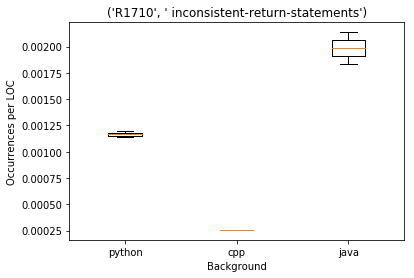

p-values:  {'java': 0.0, 'cpp': 0.0}


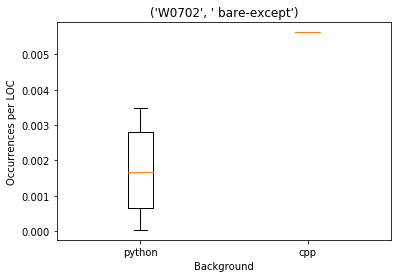

p-values:  {'cpp': 0.0}


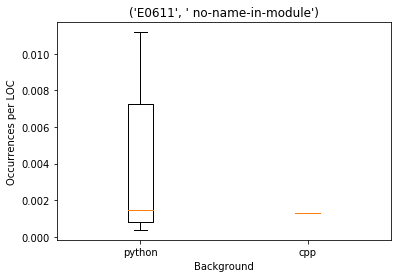

p-values:  {'cpp': 0.0}


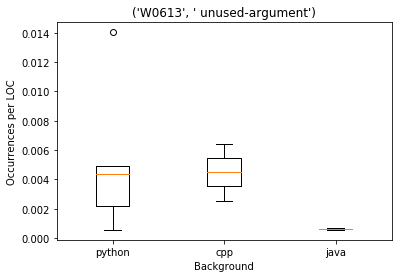

p-values:  {'java': 0.0, 'cpp': 0.0}


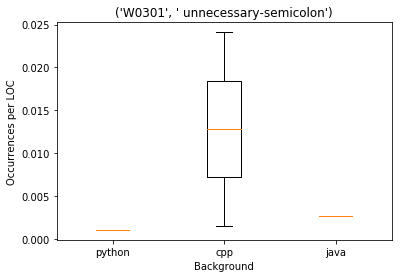

p-values:  {'java': 0.0, 'cpp': 0.0}


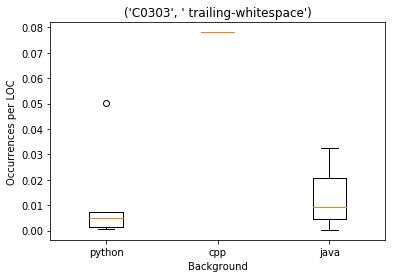

p-values:  {'java': 0.0, 'cpp': 0.0}


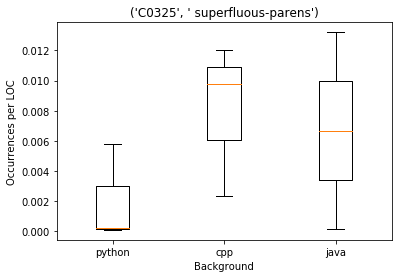

p-values:  {'java': 0.0, 'cpp': 0.0}


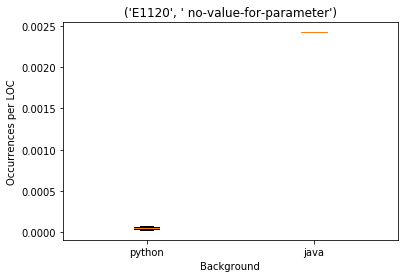

p-values:  {'java': 0.0}


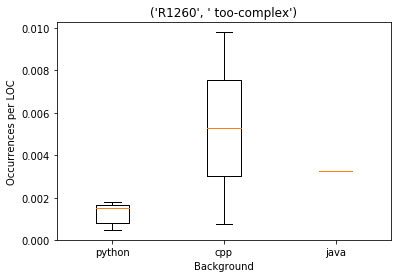

p-values:  {'java': 0.0, 'cpp': 0.0}


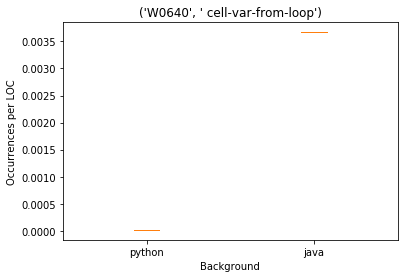

p-values:  {'java': 0.0}


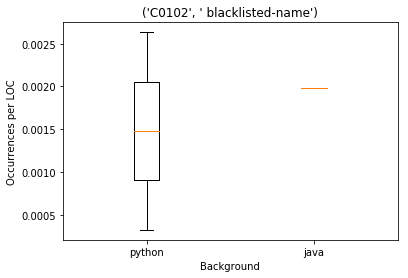

p-values:  {'java': 0.0}


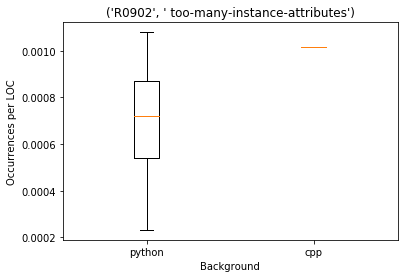

p-values:  {'cpp': 0.0}


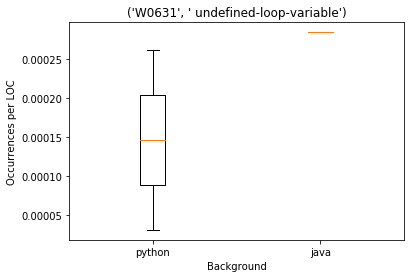

p-values:  {'java': 0.0}


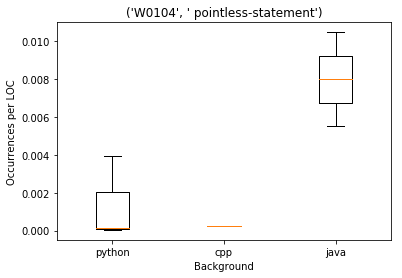

p-values:  {'java': 0.0, 'cpp': 0.0}


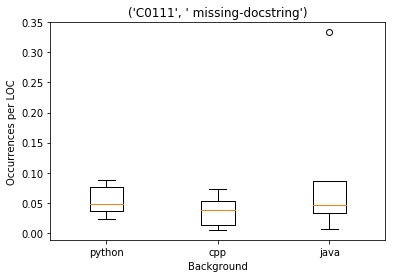

p-values:  {'java': 0.0, 'cpp': 0.0}


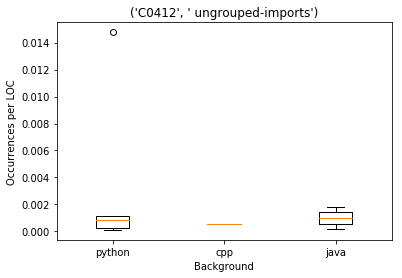

p-values:  {'java': 0.0, 'cpp': 0.0}


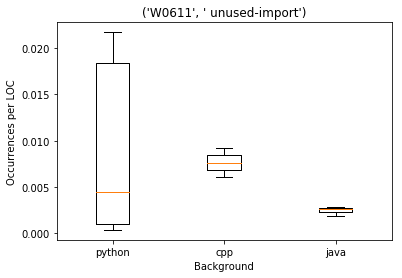

p-values:  {'java': 0.0, 'cpp': 0.0}


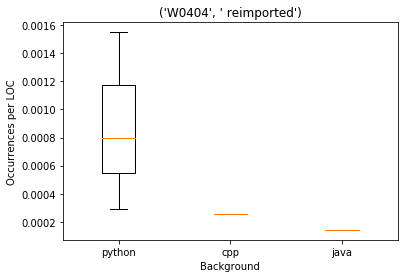

p-values:  {'java': 0.0, 'cpp': 0.0}


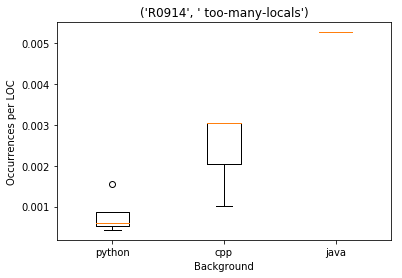

p-values:  {'java': 0.0, 'cpp': 0.0}


In [38]:
for err_code, p_vals in plot_signifs.items():
    target_data = [e[0] for e in normalized_error_occurences[TARGET_LANGUAGE][err_code]]
    plot_data = [target_data]
    plot_labels = [TARGET_LANGUAGE]
    for bg_lang in BG_LANGS:
        if err_code in normalized_error_occurences[bg_lang].keys():
            plot_data.append([e[0] for e in normalized_error_occurences[bg_lang][err_code]])
            plot_labels.append(bg_lang)
    plt.boxplot(plot_data)
    plt.title(err_code)
    plt.xlabel('Background')
    plt.ylabel('Occurrences per LOC')
    plt.xticks(range(1, len(plot_labels) + 1), plot_labels)
    fig = plt.gcf()
    # fig.set_size_inches(18.5, 5)
    # plt.yscale('log')  
    plt.show()
    print('p-values: ', p_vals)
    plt.clf()

#### Tracing Outliers

If you want to have a look at a specific outlier, you can get the path of the project by looking up the highest values (for example) in the corresponding dictionary.

In [40]:
trace_lang = 'java'
trace_code = ('R0914', 'too-many-locals')
# These are examples you could look up, change this according to your needs
print([x[1] for x in sorted(normalized_error_occurences[trace_lang][trace_code], key=lambda e: e[0])])
# This prints all projects where this error was found, ascending with the amount. Adjust this to your needs.

['/mnt/brick/crm-repos/shorschig/lics/java/university']


## Further Thoughts

### Inaccuracies

There were some assumptions I made that have a strong influence on the outcome and should maybe be adressed in future work:
+ __Project languages__: I assumed, when creating the table I worked with, that the only programming experience a user gets is from editing a file with a specific file ending. So e.g. '.py' for Python files. This is a pretty strong limitation on actual LOC written in that specific langauge and only an approximation.
+ __Linear experience progression__: When choosing the experience multiplier threshold, it was more or less an assumption of a linear progression of the experience. But this is not necessarily so, for example a programmer having written 5 times the amount of Python than Java does not necessarily have 5 times the experience or is a better programmer in that language. This is a topic that could further be explored.
+ __Project contribution__: For now, when I found a candidate, I just fetch all the projects this user contributed to. This does not mean that he is the author of most of these files. It could be that he just pushed a lot of site packages to the repository or worked with other, more experienced programmers, which could distort my analysis enormously. The best way to prevent this would be doing analysis only on specific files or even changes, but then the linter has to be adjusted accordingly (a list of changes is not always valid code).

So, while the topic is still an open field, this marks the end of the seminar and my work on this topic. I hope you, dear reader, enjoyed looking at my results as much as I enjoyed producing them.